# LangGraph 실습

## 1. langchain 패키지 설치
- openai api는 파이썬용 SDK 를 설치하거나 HTTP Client 를 사용하여 REST API 를 직접 호출하는 방식으로 사용할 수 있습니다.
- 프로그래밍 언어 선택에 제약이 있는 경우를 제외하면 대부분 파이썬 SDK 를 설치하여 사용합니다.

In [1]:
!pip install langchain langgraph openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.4/401.4 kB 10.9 MB/s eta 0:00:0000:01


## 2. Azure OpenAI 리소스 정보 설정
- openai API 를 호출하기 위해서는 API key 를 입력해야합니다.
- Azure OpenAI 의 경우, API key 뿐만 아니라 endpoint, deployment name 등이 추가로 필요합니다.
- 이 실습 환경에서는 Azure OpenAI 를 사용하기 위해 필요한 정보를 환경변수로 제공합니다.

In [10]:
# 실습용 AOAI 환경변수 읽기 (.env 파일 사용 시 아래 load_dotenv() 필요)
import os
from dotenv import load_dotenv
load_dotenv()

AOAI_ENDPOINT=os.getenv("AOAI_ENDPOINT")
AOAI_API_KEY=os.getenv("AOAI_API_KEY")
AOAI_DEPLOY_GPT4O=os.getenv("AOAI_DEPLOY_GPT4O")
AOAI_DEPLOY_GPT4O_MINI=os.getenv("AOAI_DEPLOY_GPT4O_MINI")
AOAI_DEPLOY_EMBED_3_LARGE=os.getenv("AOAI_DEPLOY_EMBED_3_LARGE")
AOAI_DEPLOY_EMBED_3_SMALL=os.getenv("AOAI_DEPLOY_EMBED_3_SMALL")
AOAI_DEPLOY_EMBED_ADA=os.getenv("AOAI_DEPLOY_EMBED_ADA")

In [25]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=AOAI_ENDPOINT,
    azure_deployment=AOAI_DEPLOY_GPT4O_MINI,
    api_version="2024-02-01",
    api_key=AOAI_API_KEY
)

In [33]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [28]:
graph_builder = StateGraph(State)

In [29]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]} #user 혹은 다른 agent가 해당 노드에게 보낸 message (= state에 저장되어 있음)

In [30]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot") #사용자가 chat을 시작하면 start에서 chat으로 연결되는 edge
graph_builder.add_edge("chatbot", END) #chat이 끝나면 end로 연결되는 edge
graph = graph_builder.compile()

In [31]:
for chunk in graph.stream(
    {"messages": [("human", "오늘 날씨 어때?")]}, stream_mode = "values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

오늘 날씨 어때?
================================== Ai Message ==================================

죄송하지만, 현재 실시간 날씨 정보를 제공할 수는 없습니다. 하지만 날씨를 확인하고 싶으시다면 기상청 웹사이트나 날씨 애플리케이션을 이용해 보시는 것을 추천합니다. 도움이 필요하시면 다른 질문 해주세요!


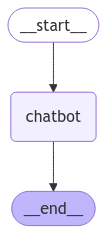

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [34]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [35]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"

In [36]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [40]:
model_with_tools = llm.bind_tools(tools)

In [41]:
model_with_tools.invoke("what's the weather in sf?").tool_calls

[{'name': 'get_weather',
  'args': {'location': 'San Francisco'},
  'id': 'call_mMum6K875BWzMwbPJwLrVyU7',
  'type': 'tool_call'}]

In [ ]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

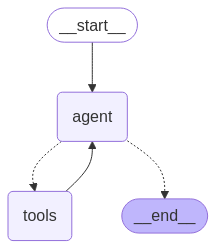

In [43]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [46]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "샌프란시스코의 날씨를 알려줘.")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

샌프란시스코의 날씨를 알려줘.
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_OkABGOH7zUFeNYZM8NrkPJco)
 Call ID: call_OkABGOH7zUFeNYZM8NrkPJco
  Args:
    location: 샌프란시스코
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================

샌프란시스코는 현재 90도(약 32도)이며 맑은 날씨입니다.
